In [1]:
from pycalphad import Database, Model, calculate, equilibrium, variables as v
from xarray import DataArray

In [5]:
class PrecipitateModel(Model):
    matrix_chempots = []
    @property
    def matrix_hyperplane(self):
        return sum(self.moles(self.nonvacant_elements[i])*self.matrix_chempots[i]
                   for i in range(len(self.nonvacant_elements)))
    @property
    def GM(self):
        return self.ast - self.matrix_hyperplane

class GibbsThompsonModel(Model):
    "Spherical particle."
    radius = 1e-6 # m
    volume = 7.3e-6 # m^3/mol
    interfacial_energy = 250e-3 # J/m^2
    elastic_misfit_energy = 0 # J/mol
    @property
    def GM(self):
        return self.ast + (2*self.interfacial_energy/self.radius + self.elastic_misfit_energy) * self.volume

In [27]:
import numpy as np

def parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    matrix_eq = equilibrium(dbf, comps, matrix_phase, conds)
    # pycalphad currently doesn't have a way to turn global minimization off and directly specify starting points
    if matrix_eq.isel(vertex=1).Phase.values.flatten() != ['']:
        raise ValueError('Matrix phase has miscibility gap. This bug will be fixed in the future')
    matrix_chempots = matrix_eq.MU.values.flatten()
    # This part will not work until mass balance constraint can be relaxed
    #precip = PrecipitateModel(dbf, comps, precipitate_phase)
    #precip.matrix_chempots = matrix_chempots
    #conds = {v.N: 1, v.P: 1e5, v.T: temp}
    #df_eq = equilibrium(dbf, comps, precipitate_phase, conds, model=precip)
    df_eq = calculate(dbf, comps, precipitate_phase, T=temp, N=1, P=1e5)
    df_eq['GM'] = df_eq.X.values[0,0,0].dot(matrix_chempots) - df_eq.GM
    selected_idx = df_eq.GM.argmax()
    return matrix_eq.isel(vertex=0), df_eq.isel(points=selected_idx)

def nucleation_barrier(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp,
                       interfacial_energy, precipitate_volume):
    "Spherical precipitate."
    matrix_eq, precip_eq = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    precip_driving_force = float(precip_eq.GM.values) # J/mol
    elastic_misfit_energy = 0 # J/m^3
    barrier = 16./3 * interfacial_energy **3 / (precip_driving_force + elastic_misfit_energy) ** 2 # J/mol
    critical_radius = 2 * interfacial_energy / ((precip_driving_force / precipitate_volume) + elastic_misfit_energy) # m
    print(temp, critical_radius)
    if critical_radius < 0:
        barrier = np.inf
    cluster_area = 4*np.pi*critical_radius**2
    cluster_volume = (4./3) * np.pi * critical_radius**3
    return barrier, precip_driving_force, cluster_area, cluster_volume, matrix_eq, precip_eq

def nucleation_rate(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    # Numbers here are made up for demonstration purposes
    interfacial_energy = 250e-3 # J/m^2
    precipitate_volume = 7.3e-6 # m^3/mol
    atomic_distance = 2e-10 # m
    n_prefactor = 1e21
    # Could retrieve from TDB in principle
    diffusivity = 2e-4 * np.exp(-142e3/(8.3145*temp)) # m^2 / s

    g_star, g_nucl, area, volume, matrix_eq, precip_eq = nucleation_barrier(dbf, comps, matrix_phase,
                                                                            matrix_comp, precipitate_phase,
                                                                            temp, interfacial_energy,
                                                                            precipitate_volume)

    zeldovich = 3 * (g_nucl ** 2) / (4*np.sqrt(np.pi*8.3145*temp) * ((area * interfacial_energy) ** (3./2))) # dim-less

    conc_diff = (precip_eq.X.values.flatten() - matrix_eq.X.values.flatten()) ** 2 /\
                (matrix_eq.X.values.flatten() * diffusivity)
    beta_attachment_rate = (area / ((atomic_distance**4) * precipitate_volume)) / conc_diff.sum()  # s^-1
    incubation_time = 1 / (2*beta_attachment_rate*zeldovich) # s
    ss_nucl_rate = n_prefactor * zeldovich * beta_attachment_rate * np.exp(-g_star/(8.3145*temp))
    return ss_nucl_rate, incubation_time

def growth_rate(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp, particle_radius):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    # Fictive; Could retrieve from TDB in principle
    mobility = 2e-4 * np.exp(-142e3/(8.3145*temp)) # m^2 / s
    mobilities = np.full(len(matrix_comp)+1, mobility)

    matrix_ff_eq, precip_eq = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    # XXX: Should really be done with global min off, fixed-phase conditions, etc.
    # As written, this will break with miscibility gaps
    particle_mod = GibbsThompsonModel(dbf, comps, precipitate_phase)
    particle_mod.radius = particle_radius
    interface_eq = equilibrium(dbf, comps, [matrix_phase, precipitate_phase], conds,
                               model={precipitate_phase: particle_mod})

    matrix_idx = np.nonzero((interface_eq.Phase==matrix_phase).values.flatten())[0]
    if len(matrix_idx) != 1:
        raise ValueError('Matrix phase has miscibility gap')
    else:
        matrix_idx = matrix_idx[0]
        matrix_interface_eq = interface_eq.isel(vertex=matrix_idx)

    precip_idx = np.nonzero((interface_eq.Phase==precipitate_phase).values.flatten())[0]
    if len(precip_idx) > 1:
        raise ValueError('Precipitate phase has miscibility gap')
    elif len(precip_idx) == 0:
        precip_conc = np.zeros(len(interface_eq.component))
        # Precipitate is metastable at this radius (it will start to dissolve)
        # Compute equilibrium for precipitate by itself at parallel tangent composition
        pt_comp = {v.X(str(comp)): precip_eq.X.values.flatten()[idx] for idx, comp in enumerate(precip_eq.component.values[:-1])}
        conds = {v.N: 1, v.P: 1e5, v.T: temp}
        conds.update(pt_comp)
        precip_interface_eq = equilibrium(dbf, comps, precipitate_phase, conds,
                               model={precipitate_phase: particle_mod})
        precip_interface_eq = precip_interface_eq.isel(vertex=0)
    else:
        precip_idx = precip_idx[0]
        precip_interface_eq = interface_eq.isel(vertex=precip_idx)
    
    eta_geo_factor = 1.0
    fluxes = matrix_interface_eq.X.values.flatten() * mobilities * \
             (matrix_ff_eq.MU.values.flatten() - precip_interface_eq.MU.values.flatten()) / \
                 (eta_geo_factor * particle_radius)
    velocities = fluxes / (precip_interface_eq.X.values.flatten() - matrix_interface_eq.X.values.flatten())
    velocity = velocities.mean()
    return velocity

dbf = Database('Al-Cu-Zr_Zhou.tdb')
comps = ['AL', 'CU', 'VA']

temps = np.linspace(300, 1500, 30)
results = []
for temp in temps:
    result, incub_time = nucleation_rate(dbf, comps, 'BCC_A2', {v.X('CU'): 0.4}, 'AL2CU', temp)
    results.append(result)

300.0 4.5604427802184823e-10
341.37931034482756 4.85381225499492e-10
382.7586206896552 5.187521158028901e-10
424.1379310344828 5.570377196180276e-10
465.51724137931035 6.013962805932017e-10
506.8965517241379 6.533858930185769e-10
548.2758620689656 7.15111256882668e-10
589.6551724137931 7.895207584352385e-10
631.0344827586207 8.808692899120282e-10
672.4137931034483 9.95532155647056e-10
713.7931034482758 1.1435193279446894e-09
755.1724137931035 1.3415140438591072e-09
796.551724137931 1.6195356752308256e-09
837.9310344827586 2.037648545704947e-09
879.3103448275863 2.736089894824693e-09
920.6896551724138 4.136114764905661e-09
962.0689655172414 8.35084687192234e-09
1003.448275862069 -2.0660185316834673e-06
1044.8275862068965 -8.414578904097055e-09
1086.2068965517242 -4.2505676352911296e-09
1127.5862068965516 -2.8595265646862606e-09
1168.9655172413793 -2.163759689052449e-09
1210.344827586207 -1.7463807521016862e-09
1251.7241379310344 -1.4682396784024408e-09
1293.103448275862 -1.2696566017189

Text(0.5, 0, 'Radius')

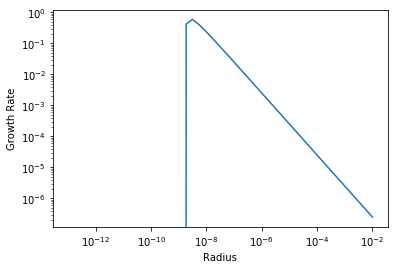

In [28]:
radii = np.logspace(-13, -2, 50)
results = []
for radius in radii:
    result = growth_rate(dbf, comps, 'BCC_A2', {v.X('CU'): 0.4}, 'AL2CU', 800, radius)
    results.append(result)
import matplotlib.pyplot as plt
plt.loglog(radii, results)
plt.ylabel('Growth Rate')
plt.xlabel('Radius')

In [30]:
time = 0
deltaT = 1e4
max_time = 1e6
times = []
results = []
current_size = 1e-10 # m
while time < max_time:
    rate = growth_rate(dbf, comps, 'BCC_A2', {v.X('CU'): 0.4}, 'AL2CU', 600, radius)
    size = current_size + rate*deltaT
    results.append(size)
    times.append(time)
    current_size = float(size)
    time += deltaT
    

Text(0, 0.5, 'Particle Size')

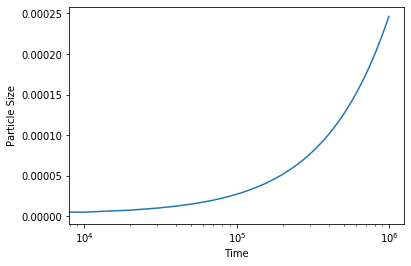

In [31]:
import matplotlib.pyplot as plt
plt.semilogx(times, results)
plt.xlabel('Time')
plt.ylabel('Particle Size')